In [268]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

path = "./PanoramaImages/ImageSet2/"
files = os.listdir(path)

images = []

for file in files[1:]:
    image_path = path + file
    img = cv.imread(image_path,0)
    img = cv.resize(img,(256,256))
    images.append(img)

sift = cv.xfeatures2d.SIFT_create()

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

# bf = cv.BFMatcher()
# matches = bf.knnMatch(des1,des2, k=2)
flann = cv.FlannBasedMatcher(index_params,search_params)

In [260]:
def panoramic_image(images,image,i):
    
    if i == len(images):
        return image
    
    if i == 0:
        img1 = images[0]
        img2 = images[1]
        
        kp1,kp2,des1,des2 = find_keypoints(img1,img2)
         
        H = find_homography(kp1,kp2,des1,des2)
        
        if len(H) > 0 :
            dst = stitch_images(img1,img2,H)
            return panoramic_image(images,dst,i+2)
    
    else:
        img1 = image
        img2 = images[i]
        
        kp1,kp2,des1,des2 = find_keypoints(img1,img2)
        
        H = find_homography(kp1,kp2,des1,des2)
        
        if len(H) > 0 :
            dst = stitch_images(img1,img2,H)
            return panoramic_image(images,dst,i+1)

        
def find_homography(kp1,kp2,des1,des2):
    matches = flann.knnMatch(des1,des2,k = 2)
    good = []
    for i , (m, n) in enumerate(matches):
        if m.distance < 0.62*n.distance:
            good.append((m.trainIdx, m.queryIdx))

    if len(good) > 4:
        pointsCurrent = kp2
        pointsPrevious = kp1

        matchedPointsCurrent = np.float32(
            [pointsCurrent[i].pt for (i, __) in good]
        )
        matchedPointsPrev = np.float32(
            [pointsPrevious[i].pt for (__, i) in good]
            )

        H, s = cv.findHomography(matchedPointsCurrent, matchedPointsPrev, cv.RANSAC, 4)
        print(H)
        return H
    else:
        print("cant find enough keypoints")
        return []
    

def stitch_images(img1,img2,H):
    dst = cv.warpPerspective(img2,H,(img2.shape[1] + img1.shape[1], img1.shape[0]))
    plt.imshow(dst),plt.title('Warped Image')
    plt.show()
    plt.figure()

    dst[:,:img1.shape[1]] = img1
    
    width = 0
    for i in range(dst.shape[1]-1 ,0 ,-1):
        if dst[0][i] != 0:
            width = i
            break
    dst = dst[:,:width+1]
    
    plt.imshow(dst)
    plt.show()
    
    return dst


def find_keypoints(img1,img2):
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    des1 = np.array(des1)
    des2 = np.array(des2)
    
    return kp1,kp2,des1,des2

[[ 1.33730351e+00  2.33815572e-01 -4.85738628e+01]
 [-1.68962331e-02  1.46200938e+00 -1.76898574e+02]
 [ 1.58147209e-05  1.71776433e-03  1.00000000e+00]]


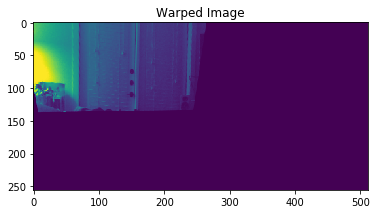

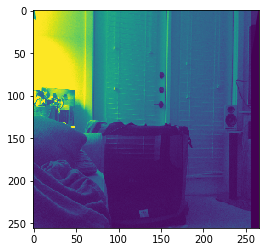

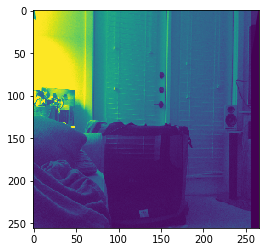

In [269]:
p_image = panoramic_image(images,images[0],0)
plt.imshow(p_image)